# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

## Libraries and Dependencies

In [1]:
#下面这行代码，是为了把自己编写的代码文件当作一共模块导入，这里是把Utilities文件夹中的plotting.py文件当作python的模块导入，对应的是下面的from plotting import newfig, savefig。路径要随着不同设备的系统做相应的修改
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../Utilities/') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。


np.random.seed(1234) #这里有变化，仅需要设置numpy的随机数生成器的种子。设置随机数生成器的种子可以确保每次运行程序时，NumPy生成的随机数序列都是一样的。

# torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

In [2]:
# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
import copy

#作用是创建N个module的深度复制，并将它们作为一个nn.ModuleList返回
def get_clones(module, N): #接受两个参数，module是一个pytorch模块，N是一个证书
    return torch.nn.ModuleList([copy.deepcopy(module) for i in range(N)])
#函数主体是一个列表推导式，它会生成一个列表，列表中包含N个module的深度复制。而nn.ModuleList是一个包含各种模块的简单列表，与普通列表相比，其重要特性是会作为模块属性时，会自动注册其包含的模块

## Physics-informed Neural Networks

In [4]:
class WaveAct(torch.nn.Module): #定义了论文中自定义的激活函数，用于对输入数据进行非线性变换
    def __init__(self):
        super(WaveAct, self).__init__()  #调用父类的__init__方法进行初始化
        #定义两个参数，初始值均设为1，并且会被自动添加到模块的参数列表中进行优化
        self.w1 = torch.nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = torch.nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

class FeedForward(torch.nn.Module): #定义前馈神经网络，由交替的线性层和自定义非线性激活函数组成
    def __init__(self, d_model, d_ff=256):  #d_model是输入数据的维度，d_ff是前馈神经网络的隐藏层神经元数量，二者均为神经元数量
        super(FeedForward, self).__init__() #调用父类的__init__方法进行初始化
        #nn.Sequential是一个有许多模块容器，这意味着属性self.linear包含多个模块：三个线性全连接层和两个WaveAct激活函数层
        self.linear = torch.nn.Sequential(*[
            torch.nn.Linear(d_model, d_ff),
            WaveAct(),
            torch.nn.Linear(d_ff, d_ff),
            WaveAct(),
            torch.nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)


class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, heads): #接受两个参数，第一个参数表示前馈神经网络的输入和输出维度，第二个参数表示注意力头的数量
        super(EncoderLayer, self).__init__() #调用父类的__init__方法进行初始化
        #实现多头注意力机制
        #第一个参数表示嵌入维度，输入和输出的维度，第二个参数表示注意力头的数量，多头注意力思想是将输入分割为多个较小的部分，如何对每个部分进行自注意力计算，最后将结果合并起来，这样可以让模型同时关注输入序列中的多个不同位置；
        #最后一个参数，为True表示输入张量形状为(batch, seq_len, embed_dim)，为False表示输入张量形状为(seq_len, batch, embed_dim)，batch表示批次大小，seq_len表示序列长度，embed_dim表示嵌入维度
        self.attn = torch.nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) 
        self.ff = FeedForward(d_model) #之前自定义的前馈神经网络
        self.act1 = WaveAct()
        self.act2 = WaveAct()
        
    def forward(self, x): #定义前向传播函数
        x2 = self.act1(x) #对于输入，先进行激活函数变换
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0] #将变换后的数据输入到多头注意力机制中，并将计算结果与原始的激活函数变化后的x相加得到新的输出
        x2 = self.act2(x) #对新的输出再进行激活函数变换
        x = x + self.ff(x2) #将变换后的数据输入到前馈神经网络中，并将计算结果与原始的激活函数变化后的x相加得到新的输出
        return x


class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()

        self.attn = torch.nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x, e_outputs): 
        x2 = self.act1(x) #对于输入，先进行激活函数变换
        x = x + self.attn(x2, e_outputs, e_outputs)[0] #将变换后的数据输入到多头注意力机制中，并将计算结果与原始的激活函数变化后的x相加得到新的输出
        x2 = self.act2(x) #对新的输出再进行激活函数变换
        x = x + self.ff(x2) #将变换后的数据输入到前馈神经网络中，并将计算结果与原始的激活函数变化后的x相加得到新的输出
        return x


class Encoder(torch.nn.Module): #Transformer 模型的编码器部分，它由多个相同的编码器层组成
    def __init__(self, d_model, N, heads):
        super(Encoder, self).__init__()
        self.N = N #定义了一个参数N，表示编码器的层数
        self.layers = get_clones(EncoderLayer(d_model, heads), N) #调用get_clones函数，将EncoderLayer复制N次，得到一个包含N个EncoderLayer的列表
        self.act = WaveAct() #定义了一个激活函数

    def forward(self, x):
        for i in range(self.N): 
            x = self.layers[i](x) #将输入数据x输入到第i个EncoderLayer中更新x
        return self.act(x) #返回激活函数变换后的x


class Decoder(torch.nn.Module): #Transformer 模型的解码器部分，它由多个相同的解码器层组成
    def __init__(self, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N #定义了一个参数N，表示解码器的层数
        self.layers = get_clones(DecoderLayer(d_model, heads), N) #调用get_clones函数，将DecoderLayer复制N次，得到一个包含N个DecoderLayer的列表
        self.act = WaveAct() #定义了一个激活函数
        
    def forward(self, x, e_outputs):
        for i in range(self.N):
            x = self.layers[i](x, e_outputs) #将输入数据x和编码器的输出e_outputs输入到第i个DecoderLayer中更新x
        return self.act(x) #返回激活函数变换后的x



class PINNsformer(torch.nn.Module): #完整的模型，包含了编码器、解码器和输出层
    def __init__(self, d_out, d_model, d_hidden, N, heads): #共有五个参数，d_out表示输出数据的维度，d_model表示输入数据的维度，d_hidden表示隐藏层的神经元数量，N表示编码器和解码器的层数，heads表示注意力头的数量
        super(PINNsformer, self).__init__() #调用父类的__init__方法进行初始化

        self.linear_emb = torch.nn.Linear(2, d_model) #定义了一个线性层，用于将输入数据的维度从2维变换为d_model维

        self.encoder = Encoder(d_model, N, heads) #编码器，由N个编码器层组成，每个编码器层的嵌入维度为d_model，注意力头的数量为heads
        self.decoder = Decoder(d_model, N, heads) #解码器，由N个解码器层组成，每个解码器层的嵌入维度为d_model，注意力头的数量为heads
        self.linear_out = torch.nn.Sequential(*[
            torch.nn.Linear(d_model, d_hidden),
            WaveAct(),
            torch.nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            torch.nn.Linear(d_hidden, d_out)
        ]) #输出层，由三个线性全连接层和两个WaveAct激活函数层交替组成，

    def forward(self, x):
        x = self.linear_emb(x) #将数据输入到线性层中进行维度变换

        e_outputs = self.encoder(x) #将变换后的数据输入到编码器中得到编码器的输出e_outputs
        d_output = self.decoder(x, e_outputs) #将变换后的数据和编码器的输出输入到解码器中得到解码器的输出d_output
        output = self.linear_out(d_output) #将解码器的输出输入到输出层中得到最终的输出
        # pdb.set_trace()
        # raise Exception('stop')
        return output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, lb, ub, nu): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #创建四个pytorch张良，将X_u的第一列赋值给self.x_u，将X_u的第二列赋值给self.t_u。转换为浮点类型，移动到指定设备上，并且这几个张量都需要计算梯度
        self.x_u = torch.tensor(X_u[:,:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:,:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:,:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:,:, 1:2], requires_grad=True).float().to(device)

        
        self.u = torch.tensor(u).float().to(device)
        

        self.nu = nu
        
        # deep neural networks
        # self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        self.dnn = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device)

        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
            lr=1.0,  #学习率设置为1
            max_iter=50000,  #最大迭代次数为50000
            max_eval=50000,  #最大评估次数为50000
            history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
            tolerance_grad=1e-10,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
            # tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
            line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        )

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #调用上面的net_u函数，计算神经网络的输出u
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx #计算f，定义见论文
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
        f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
        loss_u = torch.mean((self.u - u_pred) ** 2) #计算loss_u，定义见论文
        loss_f = torch.mean(f_pred ** 2) #计算loss_f，定义见论文
        
        loss = loss_u + loss_f #计算总的loss
        
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        self.iter += 1 #每调用一次损失函数，迭代次数加1

        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中
        
        return loss #返回总的loss
    
    def train(self, nIter, nIterLBFGS):
        self.dnn.train() #将神经网络设置为训练模式而不是评估模式


        # 初始化一个列表来存储每个epoch的权重矩阵
        self.weights = []   


        #使用SGD优化器优化nIter次
        for epoch in tqdm(range(nIter),desc = 'SGD'):
            u_pred = self.net_u(self.x_u, self.t_u)
            f_pred = self.net_f(self.x_f, self.t_f)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)

            # Backward and optimize
            self.optimizer_SGD.zero_grad()
            loss.backward()
            self.optimizer_SGD.step()

            #record the loss value
            self.loss_value.append(loss)

    


        # #使用Adam优化器优化nIter次
        # for epoch in tqdm(range(nIter),desc = 'Adam'):
        #     u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
        #     f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
        #     loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2) #计算损失函数
            
        #     # Backward and optimize
        #     self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        #     loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        #     self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
        #     #record the loss value
        #     self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

    
        
        
        
        #使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.optimizer_LBFGS.step(self.loss_func) #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化


            
    def predict(self, X):
        x = torch.tensor(X[:,:, 0:1], requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(X[:,:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x, t) #调用之前定义的函数得到神经网络的输出u,以及f
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f

In [ ]:
#定义一个函数，用于生成一个时间序列。传入参数为src，即原始训练数据，形状一般为（n,2），第一列代表x，第二列代表t，num_step为时间步数，step为时间步长
def make_time_sequence(train_data, num_step=5, step=1e-4):
    dim = num_step
    #先将src在第二个维度上增加一个维度，形状变为(N, ？, 2)，然后使用np.repeat函数将增加维度后的src在第二个维度上重复dim=num_step次，形状变为(N, num_step, 2)
    train_data = np.repeat(np.expand_dims(train_data, axis=1), dim, axis=1)  # (n, num_step, 2)
    
    for i in range(num_step):
        train_data[:,i,-1] += step*i #每次循环，先取第一个维度的所有行、第i列、最后一个维度的元素（代表t），即在时间上递增
    return train_data

## Configurations

In [6]:
nu = 0.01/np.pi
#设置噪声水平为0
noise = 0.0        

N_u = 100
N_f = 1000
#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
# layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
#读取名为burgers_shock的Matlab文件，文件中的数据存储在data变量中。这里的路径也要随着设备的情况修改 
data = scipy.io.loadmat('data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组         

# Doman bounds，分别获得X_star的相应列上的最小值和最大值，赋值给lb和ub,也就是说lb是x和t的最小值，ub是x和t的最大值，即lb和ub分别为[-1,0]和[1,1]
lb = X_star.min(0)
ub = X_star.max(0)    


#生成初值和边界值的训练基础数据
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #分别取X，T的第一行的转置(分别是x和全0列)，分别构成xx1的第一列和第二列
uu1 = Exact[0:1,:].T #取Exact的第一行的转置，赋值给uu1
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #分别取X，T的第一列(分别是全-1列和t)，分别构成xx2的第一列和第二列
uu2 = Exact[:,0:1] #取Exact的第一列，赋值给uu2
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #分别取X，T的最后一列(分别是全1列和t)，分别构成xx3的第一列和第二列
uu3 = Exact[:,-1:] #取Exact的最后一列，赋值给uu3

X_u_train = np.vstack([xx1, xx2, xx3]) #X_u_train=(xx1;xx2;xx3)
#生成配位点训练基础数据
X_f_train = lb + (ub-lb)*lhs(2, N_f)  #lhs函数采用拉丁超采样方法，生成一个近似均匀分布的多维样本点集，表示生产的样本有两个特征，共N_f个样本数量，所以返回的是一个形状为（N_f，2）的数组，每一行都是一个2维的样本点，所有样本点都在[0,1]范围内，并对该样本集进行缩放，把每个样本从[0,1]区间缩放到[lb,ub]区域内，即得到了指定范围内均匀分布的样本X_f_train。

X_f_train = np.vstack((X_f_train, X_u_train)) #按行堆叠数组，即将X_f_train和X_u_train按行合并，得到一个新的数组X_f_train

u_train = np.vstack([uu1, uu2, uu3]) #u_train=(uu1;uu2;uu3)

#从所有的初值边界值训练基础数据中选取N_u=100个点
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False) #从0~数组X_u_train的行数 中随机选择N_u个数，replace=False表示不允许重复选择，最后将这N_u个数赋值给idx
X_u_train = X_u_train[idx, :] #从X_u_train中选取idx对应的的N_u行，赋值给X_u_train
u_train = u_train[idx,:] #从u_train中选取idx对应的的N_u行，赋值给u_train

## Training

In [7]:
#创建PINN模型并输入各种参数     
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, lb, ub, nu)

#获取当前时间并赋值给start_time  
start_time = time.time()   
#开始训练模型            
model.train(500)
#训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
elapsed = time.time() - start_time
#打印训练所花时间                
print('Training time: %.4f' % (elapsed))



100%|██████████| 500/500 [00:16<00:00, 30.59it/s]


Training time: 16.3466


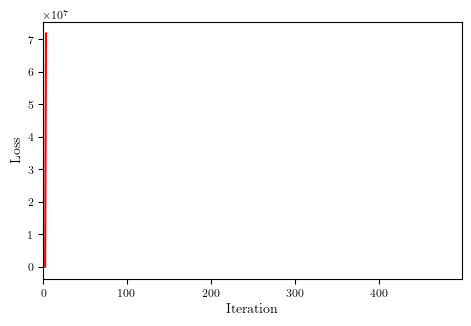

In [10]:
#打印误差随迭代次数的变化
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()
# print(trainloss)
# print(trainloss.shape)
indices=list(range(len(trainloss)))
plt.figure()
plt.plot(indices,trainloss,color='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlim([0,max(indices)]) # 设置x轴的范围
# plt.ylim([0,0.2]) # 设置y轴的范围
plt.show()

In [9]:
print(trainloss)

[3.4706268e-01 1.0087526e+01 7.1220404e+02 7.1847032e+07           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
      

In [18]:
#这是测试

#从所有的初值边界值训练基础数据中选取2000个点
idx = np.random.choice(X_star.shape[0], 2000, replace=False) #从0~数组X_u_train的行数 中随机选择N_u个数，replace=False表示不允许重复选择，最后将这N_u个数赋值给idx
X_star_ceshi = X_star[idx, :] #从X_u_train中选取idx对应的的N_u行，赋值给X_u_train
u_star_ceshi = u_star[idx, :] #从u_train中选取idx对应的的N_u行，赋值给u_train



#用训练好的模型调用predict方法进行预测，返回两个值（均为数组）
u_pred_ceshi, f_pred_ceshi = model.predict(X_star_ceshi)

print(u_pred_ceshi.shape)
print(u_pred_ceshi)
print(u_star_ceshi)


# #计算误差（基于2范数）        
# error_u_ceshi = np.linalg.norm(u_star_ceshi-u_pred_ceshi,2)/np.linalg.norm(u_star_ceshi,2)
# #打印误差值
# print('Error u: %e' % (error_u_ceshi))                     



# #使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
# U_pred_ceshi = griddata(X_star_ceshi, u_pred_ceshi.flatten(), (X, T), method='cubic')


(2000, 1)
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[-0.25568249]
 [-0.27984003]
 [-0.81650939]
 ...
 [-0.27193544]
 [ 0.62298123]
 [ 0.89549216]]


In [17]:
# 假设我们将X_star分割成10个部分
num_splits = 5
X_star = torch.tensor(X_star).to(device)
split_X_stars = torch.chunk(X_star, num_splits)

# 对每个部分分别进行预测
u_preds = []
f_preds = []
for split_X_star in split_X_stars:
    u_pred, f_pred = model.predict(split_X_star)
    u_pred = torch.from_numpy(u_pred).to(device)  # 转换为PyTorch张量
    f_pred = torch.from_numpy(f_pred).to(device)  # 转换为PyTorch张量
    u_preds.append(u_pred)
    f_preds.append(f_pred)

# 将结果合并
u_pred = torch.cat(u_preds)
f_pred = torch.cat(f_preds)


X_star = X_star.cpu().detach().numpy()  # 转换为NumPy数组
u_pred = u_pred.cpu().detach().numpy()  # 转换为NumPy数组
f_pred = f_pred.cpu().detach().numpy()  # 转换为NumPy数组


print(np.any(np.isnan(u_star)))
print(np.any(np.isnan(u_pred)))
print(np.any(np.isinf(u_star)))
print(np.any(np.isinf(u_pred)))

print(u_pred)


# # #用训练好的模型调用predict方法进行预测，返回两个值（均为数组）
# # u_pred, f_pred = model.predict(X_star)
# #计算误差（基于2范数）        
# error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
# #打印误差值
# print('Error u: %e' % (error_u))                     



#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
#计算插值方法的误差
Error = np.abs(Exact - U_pred)

C:\Users\lcy\AppData\Local\Temp\ipykernel_211248\812898094.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
C:\Users\lcy\AppData\Local\Temp\ipykernel_211248\812898094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)


False
True
False
False
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]


## Visualizations

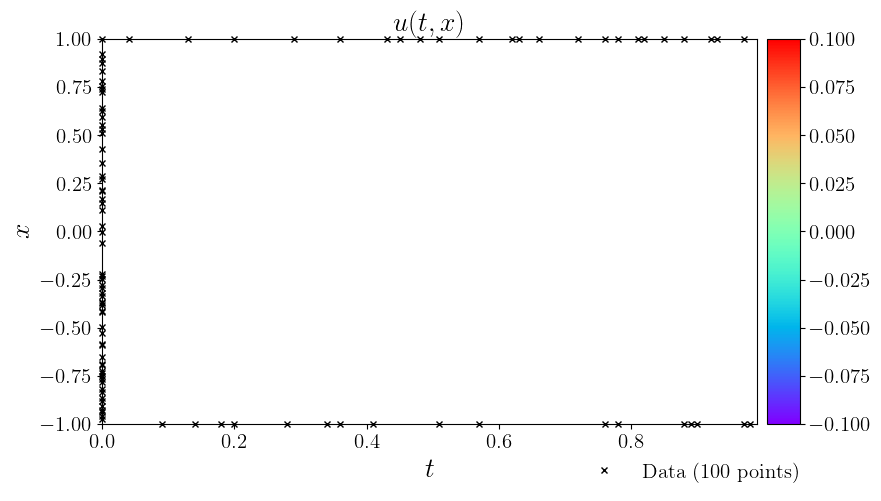

In [14]:
###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  


#在图上绘制三条虚线
line = np.linspace(x.min(), x.max(), 2)[:,None]#生成了一个包含2个等间距的数值的数组，这些数值在 x.min() 到 x.max() 之间。[:,None] 是一个索引操作，用于将一维数组转换为二维数组。这里其实就是[-1;1]
#第一个参数是虚线的x坐标，line是虚线y的坐标，第三个参数是虚线的样式，w表示白色，-表示实线，最后一个参数表示虚线的参数是1
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    


#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

C:\Users\lcy\AppData\Local\Temp\ipykernel_211248\3193111900.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs1[0, 0])  #在gs1[0,0]指定的位置，也就是网格的第一行第一列，创建了第一个子图，并将返回的axes对象赋值给ax。


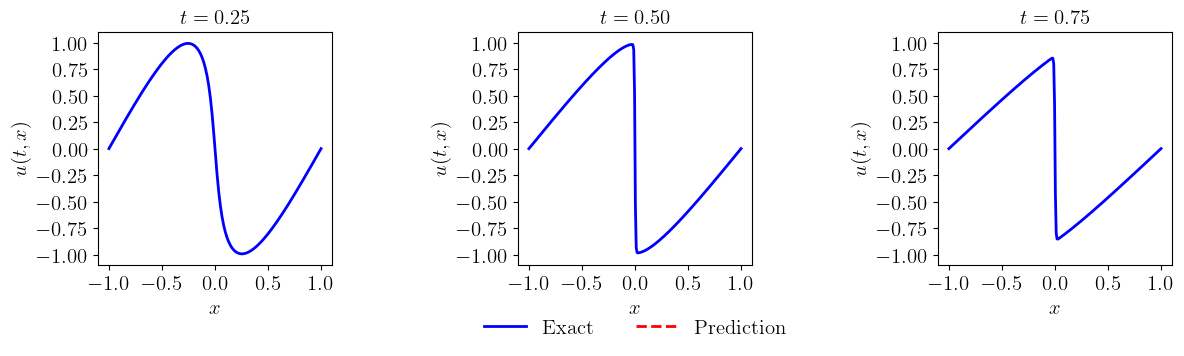

In [11]:
####### Row 1: u(t,x) slices ################## 


fig = plt.figure(figsize=(14, 10))#这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽14英寸高10英寸
ax = fig.add_subplot(111)#在图形的1*1网格的第一个位置添加一个子图

gs1 = gridspec.GridSpec(1, 3)#创建一个1×3的网络，用于存放子图
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)  #更新该网络的参数，第一个表示子图的顶部位置为0.567，第二个参数表示子图的底部位置为0.33，第三个表示子图左侧的位置为0.1，第四个参数表示子图的右侧位置为0.9，第五个参数表示子图之间的宽度为0.5

ax = plt.subplot(gs1[0, 0])  #在gs1[0,0]指定的位置，也就是网格的第一行第一列，创建了第一个子图，并将返回的axes对象赋值给ax。
#绘制了两条线，一条表示精确值，一条表示预测值
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')   #第一个参数表示x轴上的坐标；第二个参数表示y轴上的坐标；第三个参数b-表示蓝色的实线；linewidth表示线的宽度为2；label表示线的标签，这条线表示实际值     
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction') #同上，红色虚线表示预测值
ax.set_xlabel('$x$') #设置子图的x轴的标签为x
ax.set_ylabel('$u(t,x)$')    #设置子图的y轴的标签为u(t,x)
ax.set_title('$t = 0.25$', fontsize = 15) #设置子图的标题为t=0.25，fontsize=10表示字体大小为15
ax.axis('square') #设置子图的纵横比为1，即正方形的区域
ax.set_xlim([-1.1,1.1]) #设置第一个子图的x轴的范围为[-1.1,1.1]
ax.set_ylim([-1.1,1.1]) #设置第一个子图的y轴的范围为[-1.1,1.1]
#将图形的标题、x轴标签、y轴标签以及所有的x轴和y轴的刻度标签的字体大小设置为15
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
#循环上，`ax.title`、`ax.xaxis.label`、`ax.yaxis.label` 分别代表图形的标题、x轴标签和y轴标签。`ax.get_xticklabels()` 和 `ax.get_yticklabels()` 方法返回的是一个包含所有x轴和y轴刻度标签的列表。
#`item.set_fontsize(15)` 是用来设置列表中的元素item的字体大小的。
    
ax = plt.subplot(gs1[0, 1]) #在gs1[0,1]指定的位置，也就是网格的第一行第二列，创建了第二个子图，并将返回的axes对象赋值给ax。
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')   #第一个参数表示x轴上的坐标；第二个参数表示y轴上的坐标；第三个参数b-表示蓝色的实线；linewidth表示线的宽度为2；label表示线的标签，这条线表示实际值    
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction') #同上，红色虚线表示预测值
ax.set_xlabel('$x$') #设置子图的x轴的标签为x
ax.set_ylabel('$u(t,x)$') #设置子图的y轴的标签为u(t,x)
ax.axis('square') #设置子图的纵横比为1，即正方形的区域
ax.set_xlim([-1.1,1.1]) #设置第二个子图的x轴的范围为[-1.1,1.1]
ax.set_ylim([-1.1,1.1]) #设置第二个子图的y轴的范围为[-1.1,1.1]
ax.set_title('$t = 0.50$', fontsize = 15) #设置子图的标题为t=0.50，fontsize=15表示字体大小为15
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)#设置子图的图例，loc='upper center'表示图例的位置是上方中间，bbox_to_anchor=(0.5, -0.15)表示图例的位置是在子图的中间下方0.15的位置，ncol=5表示图例的列数为5，frameon=False表示不显示图例的边框；最后一个参数设置图例属性，接受字典作为参数，这里表示将图例的字体大小设置为15
#将图形的标题、x轴标签、y轴标签以及所有的x轴和y轴的刻度标签的字体大小设置为15
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
#循环上，`ax.title`、`ax.xaxis.label`、`ax.yaxis.label` 分别代表图形的标题、x轴标签和y轴标签。`ax.get_xticklabels()` 和 `ax.get_yticklabels()` 方法返回的是一个包含所有x轴和y轴刻度标签的列表。
#`item.set_fontsize(15)` 是用来设置列表中的元素item的字体大小的。
    
ax = plt.subplot(gs1[0, 2]) #在gs1[0,2]指定的位置，也就是网格的第一行第三列，创建了第三个子图，并将返回的axes对象赋值给ax。
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')  #第一个参数表示x轴上的坐标；第二个参数表示y轴上的坐标；第三个参数b-表示蓝色的实线；linewidth表示线的宽度为2；label表示线的标签，这条线表示实际值
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction') #同上，红色虚线表示预测值
ax.set_xlabel('$x$') #设置子图的x轴的标签为x
ax.set_ylabel('$u(t,x)$') #设置子图的y轴的标签为u(t,x)
ax.axis('square') #设置子图的纵横比为1，即正方形的区域
ax.set_xlim([-1.1,1.1]) #设置第三个子图的x轴的范围为[-1.1,1.1]
ax.set_ylim([-1.1,1.1]) #设置第三个子图的y轴的范围为[-1.1,1.1]
ax.set_title('$t = 0.75$', fontsize = 15) #设置子图的标题为t=0.75，fontsize=15表示字体大小为15
#将图形的标题、x轴标签、y轴标签以及所有的x轴和y轴的刻度标签的字体大小设置为15
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
#循环上，`ax.title`、`ax.xaxis.label`、`ax.yaxis.label` 分别代表图形的标题、x轴标签和y轴标签。`ax.get_xticklabels()` 和 `ax.get_yticklabels()` 方法返回的是一个包含所有x轴和y轴刻度标签的列表。
#`item.set_fontsize(15)` 是用来设置列表中的元素item的字体大小的。

plt.show() #显示所有打开的图形的函数

In [12]:
pp=0 #定义一个变量pp，用于存储参数数量
    #遍历模型的所有参数
for p in list(model.dnn.parameters()): #model.parameters()返回模型的所有参数，list将其转换为列表，p代表每一个参数
    nn=1 #定义一个变量nn，用于存储该参数数量
    for s in list(p.size()):  #p.size()是一个元组，包含了参数p在每个维度上的大小，list将其转换为列表，s代表每一个维度的大小
        nn = nn*s #将每个维度的大小相乘，得到该参数的数量。当遍历完p的所有维度后，nn即为该参数的数量
    pp += nn

print(pp)

453561
